In [15]:
"""
Otus, курс Data Scientist, старт дек.2018
Задание к уроку N1

Задача: Анализируем сообщения из vk.com

План работ.

Этап 1 - отображен в этом блокноте.
Выгружаем некоторое кол-во сообщений, сохраняем, преобразуем в csv-формат, проводим exploratory-анализ - какие данные есть,
что в них может быть интересного.
Задача на этап 1: придумать вопрос, на который будем искать ответ.

Этап 2 - отображен в python-проекте gathering.
Выгружаем данные, в минимально необходимом количестве, преобразуем в формат, удобный для анализа.
Проводим анализ с целью получить ответ на вопрос.
Задача на этап 2: на поставленный вопрос
либо получить ответ с некоторой достоверностью,
либо показать, что этих данных недостаточно для получения ответа.
"""

'\nOtus, курс Data Scientist, старт дек.2018\nЗадание к уроку N1\n\nЗадача: Анализируем сообщения из vk.com\n\nПлан работ.\n\nЭтап 1 - отображен в этом блокноте.\nВыгружаем некоторое кол-во сообщений, сохраняем, преобразуем в csv-формат, проводим exploratory-анализ - какие данные есть,\nчто в них может быть интересного.\nЗадача на этап 1: придумать вопрос, на который будем искать ответ.\n\nЭтап 2 - отображен в python-проекте gathering.\nВыгружаем данные, в минимально необходимом количестве, преобразуем в формат, удобный для анализа.\nПроводим анализ с целью получить ответ на вопрос.\nЗадача на этап 2: на поставленный вопрос\nлибо получить ответ с некоторой достоверностью,\nлибо показать, что этих данных недостаточно для получения ответа.\n'

In [16]:
import vk_api
import io
import json, codecs
import time

In [17]:
"""
Загружаем данные из vk_api, сохраняем на диск
"""

'\nЗагружаем данные из vk_api, сохраняем на диск\n'

In [18]:
# credentials: нужно указать логин/пароль к vk.com
# чтобы случайно не закомитить версию с логин/пароль - выносим эти данные в отдельный файл, который исключаем в .gitignore
credentialsFileName = "vk_login_password.txt" # формат файла: 1-я строка = логин, 2-я строка = пароль
# затираем значения, которые могли сохраниться с прошлых запусков (в notebook)
login = '+71231234567' 
password = ''

# загружаем значения из файла
try:
    loginFile = open(credentialsFileName, 'r')
    login = loginFile.readline().strip() # в формате: '+71231234567'
    password = loginFile.readline().strip()
except IOError:
    print ("No file with login/password: создайте файл " + credentialsFileName + ", в котором 1-я строка = логин, 2-я строка = пароль")

In [19]:
# используем:
#  wrapper-lib vk_api: https://github.com/python273/vk_api
#  описание Api от vk: https://vk.com/dev/groups.search?params[q]=bitcoin&params[future]=0&params[market]=0&params[offset]=3&params[count]=3&params[v]=5.92

In [20]:
# параметры запуска
GROUP_KEYWORD = 'bitcoin' # интересуют сообщества, в названии которых есть такое слово
COUNT_GROUPS = 50 # обработаем столько сообществ
COUNT_MESSAGES_PER_GROUP = 100 # в каждом сообществе, со стены возьмем столько сообщений

In [21]:
# получаем соединение, api
vk_session = vk_api.VkApi(login, password, scope='wall')
vk_session.auth(token_only=True)
api = vk_session.get_api()

In [22]:
# константы и правила, которые используем при работе с файлами
FOLDER_PREFIX = './files/' # folder, в которую складываем файлы
FILE_EXTENSION = '.txt' # расширение для json-файлов

def fileNameFunc(rawFileName):
    return FOLDER_PREFIX + rawFileName + FILE_EXTENSION

In [23]:
# Данные по сообществам - получаем по http
def obtainGroups(api, keyword, count):
    print("obtainGroups, keyword=" + keyword + ", count=" + str(count))
    results = api.groups.search(q=keyword, count=count)
    return results['items']

In [24]:
# получить N записей со стены сообщества/пользователя
def obtainWallItems(api, owner_id, count):
    # protection: проверяем входные значения
    if(count > 100): # todo: можно приделать scroll, то есть, разбить запрос на несколько, в каждом count не более 100
        raise AssertionError("count должен быть <= 100, но передали:" + str(count))

    # основная часть
    results = api.wall.get(owner_id=owner_id, filter = 'owner', count = count, offset=0)
    print("obtainWallItems, owner_id=" + str(owner_id) + ", retrieve " + str(len(results['items'])) + ", of total " + str(results['count']))
    return results['items']

# для напоминания - сохраним в комментариях альтернативный метод vk_api для получения сообщений со стены сообщества
#tools = vk_api.VkTools(vk_session)
#wall = tools.get_all('wall.get', 10, {'owner_id': -92718200, 'filter':'owner'})

In [25]:
# записываем json в файл
def writeJsonToFile(fileName, jsonData):
    with io.open(fileName, 'w', encoding='utf-8') as f:
        f.write(json.dumps(jsonData, ensure_ascii=False, sort_keys=True, indent=4))

In [26]:
# получаем все интересующие сообщества, записываем в файл
groups = obtainGroups(api, 'bitcoin', COUNT_GROUPS)
writeJsonToFile(fileNameFunc('groups'), groups)

obtainGroups, keyword=bitcoin, count=50


In [27]:
# отфильтруем сообщества - нам нужны только те, у которых есть доступ к сообщениям на стене
group_ids = []
for group in groups:
    if(group['is_closed'] == 0):
        group_ids.append(group['id'])
    else:
        print('skip group:' + str(group['id']))
print('total groups для обработки: ' + str(len(group_ids)))

skip group:16219861
total groups для обработки: 49


In [28]:
# для каждого сообщества - получаем сообщения со стены и записваем в соотв.файл
counter = 1 # счетчик, используем в названии файлов
for group_id in group_ids:
    vk_id = -1 * group_id # vk_api.wall.get по наличию знака минус - определяет, что требуется именно сообщество
    items = obtainWallItems(api=api, owner_id=vk_id, count=COUNT_MESSAGES_PER_GROUP)
    rawFileName = str(counter) + "_" + str(group_id)
    writeJsonToFile(fileNameFunc(rawFileName), items)
    counter = counter + 1
    time.sleep(0.5) # соблюдаем этикет

obtainWallItems, owner_id=-46371384, retrieve 100, of total 48428
obtainWallItems, owner_id=-92718200, retrieve 100, of total 10908
obtainWallItems, owner_id=-632045, retrieve 100, of total 28652
obtainWallItems, owner_id=-93604475, retrieve 100, of total 14366
obtainWallItems, owner_id=-59454515, retrieve 100, of total 31644
obtainWallItems, owner_id=-79363873, retrieve 100, of total 830
obtainWallItems, owner_id=-51789870, retrieve 100, of total 13982
obtainWallItems, owner_id=-92357206, retrieve 100, of total 133
obtainWallItems, owner_id=-101271420, retrieve 100, of total 5135
obtainWallItems, owner_id=-29387592, retrieve 100, of total 1759
obtainWallItems, owner_id=-158943684, retrieve 100, of total 149
obtainWallItems, owner_id=-122422421, retrieve 100, of total 6593
obtainWallItems, owner_id=-74106120, retrieve 1, of total 1
obtainWallItems, owner_id=-50725681, retrieve 100, of total 1398
obtainWallItems, owner_id=-140465118, retrieve 33, of total 33
obtainWallItems, owner_id=-5

In [29]:
"""
Анализируем сохраненные данные
"""

'\nАнализируем сохраненные данные\n'

In [30]:
# пройти по всем файлам, которые с названием [N]_[id].txt
# 1. Определяем набор полей, которые интересуют
#   1.1 собираем набор существующих полей -> просматриваем, выбираем те, которые интересуют
#   1.2 по выбранным полям - составляем статистику, уточняем, что именно будем выгружать
# 2. Составляем csv-файл со всеми сообщениями, сохраняем

In [31]:
from os import listdir
from os.path import isfile, join
import re
import csv

In [32]:
# функции и константы

RESULTS_FILE_NAME = 'result.csv'
SCRAPPED_DATA_FILE_REGEXP = re.compile(r'^([\d]+)_([\d]+).*$')

# проанализировать массив json - какие поля встречаются
def fieldsIn(fileContent):
    result = []
    for message in fileContent:
        for key, value in message.items():
            if(key not in result):
                result.append(key)
    return result

# объединяем списки, оставляем уникальные элементы
def clueFiledsFunc(acc, addFields):
    for field in addFields:
        if(field not in acc):
            acc.append(field)
    return acc

# определяем, какие поля встречаются в загруженных данных
def revealFieldNames(fileNameList):
    fields = []
    for fileName in scrapped_data_files:
        with io.open(join(FOLDER_PREFIX, fileName), 'r', encoding='utf-8') as f:
            fileContent = json.load(f)
            fields = clueFiledsFunc(fields, fieldsIn(fileContent))
    return fields

In [33]:
# названия файлов со scrapped данными
scrapped_all_files = [f for f in listdir(FOLDER_PREFIX) if isfile(join(FOLDER_PREFIX, f))]
# только те файлы, которые про сообщения на стене сообщества
scrapped_data_files = []
regexp = SCRAPPED_DATA_FILE_REGEXP
for fileName in scrapped_all_files:
    if(regexp.search(fileName)): 
        scrapped_data_files.append(fileName)

In [34]:
fields = revealFieldNames(scrapped_data_files)
print(fields)

['attachments', 'comments', 'date', 'from_id', 'id', 'is_favorite', 'likes', 'marked_as_ads', 'owner_id', 'post_source', 'post_type', 'reposts', 'text', 'views', 'is_pinned', 'signer_id', 'copy_history']


In [35]:
# поля, которые интересуют
actual_fields = {
    'comments_count': 'comments.count',
    'date':'date',
    #'is_favorite':'is_favorite', # df['is_favorite'].value_counts() - найдено, что всегда 1 значение
    #'is_pinned':'is_pinned', # df['is_pinned'].value_counts() - найдено, что всегда 1 значение
    #'likes_can_like':'likes.can_like', # df['likes_can_like'].value_counts() - найдено, что всегда 1 значение
    #'likes_can_publish':'likes.can_publish', # df['likes_can_publish'].value_counts() - найдено, что всегда 1 значение
    'likes_count':'likes.count',
    'marked_as_ads':'marked_as_ads',
    'post_source':'post_source.type',
    #'post_type':'post_type', # df['post_type'].value_counts() - найдено, что всегда 1 значение
    'reposts_count':'reposts.count',
    'text':'text',
    'views_count':'views.count'
}
# в обработанном виде
csv_fields = []
json_fields = []
for key, value in actual_fields.items():
    csv_fields.append(key)
    json_fields.append(value)

In [36]:
# получаем значение поля в json
def revealFieldValue(jsonData,fieldPath):
    none_value = ''
    path = fieldPath.split('.')
    data = jsonData
    for step in path[:-1]:
        if step in data:
            data = data[step]
        else:
            return none_value
    data = data.get(path[-1], none_value)
    #print(data)
    return data

In [37]:
# из объекта - получаем строку для csv
def produceLine(jsonData, fieldsList):
    result = []
    for field in fieldsList:
        data = revealFieldValue(jsonData, field)
        result.append(data)
    return result

# из файла со scrapped_data получаем строки для csv
def produceCsvRowsForFile(fileName, fieldsList):
    group_id = SCRAPPED_DATA_FILE_REGEXP.match(fileName).group(2)
    result = []
    with io.open(join(FOLDER_PREFIX, fileName), 'r', encoding='utf-8') as f:
        fileContent = json.load(f)
        for doc in fileContent:
            row = [group_id] + produceLine(doc, fieldsList)
            #row.append(group_id)
            result.append(row)
    return result
            
# для всех перечисленных файлов - записываем получаемые строки в csv (в памяти держим строки только для одного файла)
def writeCsvLinesByFiles(csvWriter, fileNameList, fieldsList):
    for fileName in fileNameList:
        print('fileName: ' + fileName)
        rows = produceCsvRowsForFile(fileName, fieldsList)
        #print("***")
        #print(rows[1])
        for row in rows:            
            csvWriter.writerow(row)
            

        

In [38]:
with open(RESULTS_FILE_NAME, 'w', newline='', encoding='utf-8') as csvFile:
    csvWriter = csv.writer(csvFile, delimiter=',')
    csvWriter.writerow(['group_id'] + csv_fields) # 1-я строка - это названия столбцов
    print(json_fields)
    writeCsvLinesByFiles(csvWriter, scrapped_data_files, json_fields)

['comments.count', 'date', 'likes.count', 'marked_as_ads', 'post_source.type', 'reposts.count', 'text', 'views.count']
fileName: 10_29387592.txt
fileName: 11_158943684.txt
fileName: 12_122422421.txt
fileName: 13_74106120.txt
fileName: 14_50725681.txt
fileName: 15_140465118.txt
fileName: 16_50061159.txt
fileName: 17_50774319.txt
fileName: 17_63382381.txt
fileName: 18_147911279.txt
fileName: 18_50774319.txt
fileName: 19_147911279.txt
fileName: 19_62032126.txt
fileName: 1_46371384.txt
fileName: 20_30451584.txt
fileName: 20_62032126.txt
fileName: 21_30451584.txt
fileName: 21_63589724.txt
fileName: 22_19354230.txt
fileName: 22_63589724.txt
fileName: 23_111315172.txt
fileName: 23_65314134.txt
fileName: 24_19354230.txt
fileName: 24_33135732.txt
fileName: 25_65314134.txt
fileName: 25_79858655.txt
fileName: 26_33135732.txt
fileName: 26_70023397.txt
fileName: 27_43011371.txt
fileName: 27_79858655.txt
fileName: 28_113755164.txt
fileName: 28_70023397.txt
fileName: 29_16269693.txt
fileName: 29_6615

In [39]:
"""
Анализируем полученные данные, чтобы выделить, какие столбцы важные
"""

'\nАнализируем полученные данные, чтобы выделить, какие столбцы важные\n'

In [40]:
import pandas as pd
import numpy as np
import matplotlib
from datetime import datetime
from datetime import date

In [41]:
df = pd.read_csv(RESULTS_FILE_NAME)
df.head()

,group_id,comments_count,date,likes_count,marked_as_ads,post_source,reposts_count,text,views_count
0,29387592,3,1551424108,8,0,vk,4,Криптовалютная биржа Coinbase уже давно вызыва...,2798.0
1,29387592,0,1551289953,3,0,vk,0,Новозеландская биржа криптовалют Cryptopia рас...,1965.0
2,29387592,5,1551209662,4,0,vk,0,Анонимному хакеру удалось перевести 2.09 милли...,2353.0
3,29387592,0,1551116634,11,0,vk,4,После недели роста криптовалютного рынка новый...,2642.0
4,29387592,0,1550835826,3,0,vk,0,Глава биржи Coinbase Брайан Армстронг (Brian A...,1929.0


In [42]:
# для удобства - создадим столбец, который представляет дату в виде "номер дня начиная от date0"
date_start = datetime(2018, 12, 1)
df['day_number'] = df['date'].apply(lambda x: (datetime.fromtimestamp(int(x)) - date_start).days)
df.head()

,group_id,comments_count,date,likes_count,marked_as_ads,post_source,reposts_count,text,views_count,day_number
0,29387592,3,1551424108,8,0,vk,4,Криптовалютная биржа Coinbase уже давно вызыва...,2798.0,90
1,29387592,0,1551289953,3,0,vk,0,Новозеландская биржа криптовалют Cryptopia рас...,1965.0,88
2,29387592,5,1551209662,4,0,vk,0,Анонимному хакеру удалось перевести 2.09 милли...,2353.0,87
3,29387592,0,1551116634,11,0,vk,4,После недели роста криптовалютного рынка новый...,2642.0,86
4,29387592,0,1550835826,3,0,vk,0,Глава биржи Coinbase Брайан Армстронг (Brian A...,1929.0,83


In [43]:
df.describe()
# по результатам - замечаем, что разброс значений велик практически в каждом столбце.
# Пока - не очень понятно, какие столбцы содержат полезную информацию.

,group_id,comments_count,date,likes_count,marked_as_ads,reposts_count,views_count,day_number
count,6.440000e+03,6440.000000,6.440000e+03,6440.000000,6440.000000,6440.000000,5.880000e+03,6440.000000
mean,7.596557e+07,10.502174,1.528703e+09,19.768944,0.005124,3.304814,1.937818e+03,-173.183540
std,4.312722e+07,184.745061,3.568685e+07,431.889545,0.071406,65.740916,4.166828e+04,413.019175
min,6.320450e+05,0.000000,1.398186e+09,0.000000,0.000000,0.000000,3.000000e+00,-1684.000000
25%,5.077432e+07,0.000000,1.527688e+09,0.000000,0.000000,0.000000,1.340000e+02,-185.000000
50%,6.358972e+07,0.000000,1.540217e+09,2.000000,0.000000,0.000000,3.350000e+02,-40.000000
75%,1.113152e+08,0.000000,1.548511e+09,7.000000,0.000000,1.000000,1.105250e+03,56.000000
max,1.627583e+08,8687.000000,1.551723e+09,32519.000000,1.000000,5075.000000,2.567593e+06,93.000000


In [44]:
# Для каждого столбца выполним такой код - проверим, что есть разнообразие в значениях
print(df['post_source'].value_counts())
# те столбцы, которые содержат только одно значение - исключаем из списка

vk     4990
api    1156
rss     200
mvk      94
Name: post_source, dtype: int64


In [45]:
# столбец 'marked_as_ads' проанализируем чуть подробней - в 1% строк значение отличается 
# -> если это происходит для одного group_id - тогда данные интереса не представляют (корелляция с group_id).
tmp_df = df[df['marked_as_ads'] == 1]
print(tmp_df['group_id'].value_counts())
# решение = оставляем столбец

92718200    13
33135732    13
93604475     3
19354230     2
51789870     1
79363873     1
Name: group_id, dtype: int64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F6F0A73DA0>,
      dtype=object)

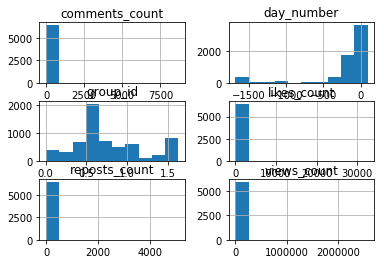

In [47]:
# посмотрим на распределения значений в каждом столбце, который оставляем
df[['group_id', 'day_number', 'comments_count', 'likes_count', 'reposts_count', 'views_count']].hist()

In [48]:
"""
Вывод:
Для анализа интересны столбцы:
    'comments_count' - кол-во комментариев,
    'date' - дата публикации,
    'likes_count' - кол-во отметок "нравится",
    'marked_as_ads' - флаг "реклама",
    'post_source' - источник публикации,
    'reposts_count' - кол-во репостов,
    'views_count' - кол-во просмотров.
И еще один столбец:
    'text' - заглавие (в анализе не участвует, но для наглядности данных - оставляем).

Итого: 7 столбцов, и строк > 1000.
Данные удовлетворяют условию сдачи задания.
"""

'\nВывод:\nДля анализа интересны столбцы:\n    \'comments_count\' - кол-во комментариев,\n    \'date\' - дата публикации,\n    \'likes_count\' - кол-во отметок "нравится",\n    \'marked_as_ads\' - флаг "реклама",\n    \'post_source\' - источник публикации,\n    \'reposts_count\' - кол-во репостов,\n    \'views_count\' - кол-во просмотров.\nИ еще один столбец:\n    \'text\' - заглавие (в анализе не участвует, но для наглядности данных - оставляем).\n\nИтого: 7 столбцов, и строк > 1000.\nДанные удовлетворяют условию сдачи задания.\n'

In [49]:
"""
По этим столбцам - можно предположить, что столбцы:
views_count, comments_count, reposts_count, likes_count
отражают интерес посетителей к публикации и вовлеченность в некоторый процесс, который публикация запускает.
Возможно, активность пользователей - различается для разных сообществ?

Вопрос N1:
Существует ли попарная корелляция между значениями в столбцах: views_count, comments_count, reposts_count, likes_count ?

Вопрос N2:
Существует ли корелляция между comments_count, reposts_count, likes_count?
То есть, возможно ли снизить размерность, если введем свойство "интерес к публикации" вместо этих 3-х столбцов?
Возможно, стоит добавить отношение к кол-ву просмотров? Пусть это будет второй вариант оценки "интерес к публикации".

Вопрос N3:
В каких сообществах сообщения вызывают наибольший интерес?
"""

'\nПо этим столбцам - можно предположить, что столбцы:\nviews_count, comments_count, reposts_count, likes_count\nотражают интерес посетителей к публикации и вовлеченность в некоторый процесс, который публикация запускает.\nВозможно, активность пользователей - различается для разных сообществ?\n\nВопрос N1:\nСуществует ли попарная корелляция между значениями в столбцах: views_count, comments_count, reposts_count, likes_count ?\n\nВопрос N2:\nСуществует ли корелляция между comments_count, reposts_count, likes_count?\nТо есть, возможно ли снизить размерность, если введем свойство "интерес к публикации" вместо этих 3-х столбцов?\nВозможно, стоит добавить отношение к кол-ву просмотров? Пусть это будет второй вариант оценки "интерес к публикации".\n\nВопрос N3:\nВ каких сообществах сообщения вызывают наибольший интерес?\n'

In [50]:
# Найдем ответ на вопрос N1

In [51]:
import pandas as pd
import numpy as np
import matplotlib
from datetime import datetime
from datetime import date

In [52]:
# константы, которые используем
RESULTS_FILE_NAME = 'result.csv' # название файла с данными

In [53]:
df = pd.read_csv(RESULTS_FILE_NAME)
df.head()

,group_id,comments_count,date,likes_count,marked_as_ads,post_source,reposts_count,text,views_count
0,29387592,3,1551424108,8,0,vk,4,Криптовалютная биржа Coinbase уже давно вызыва...,2798.0
1,29387592,0,1551289953,3,0,vk,0,Новозеландская биржа криптовалют Cryptopia рас...,1965.0
2,29387592,5,1551209662,4,0,vk,0,Анонимному хакеру удалось перевести 2.09 милли...,2353.0
3,29387592,0,1551116634,11,0,vk,4,После недели роста криптовалютного рынка новый...,2642.0
4,29387592,0,1550835826,3,0,vk,0,Глава биржи Coinbase Брайан Армстронг (Brian A...,1929.0


In [54]:
# для удобства - создадим столбец, который представляет дату в виде "номер дня начиная от date0"
date_start = datetime(2018, 12, 1)
df['day_number'] = df['date'].apply(lambda x: (datetime.fromtimestamp(int(x)) - date_start).days)
df.head()

,group_id,comments_count,date,likes_count,marked_as_ads,post_source,reposts_count,text,views_count,day_number
0,29387592,3,1551424108,8,0,vk,4,Криптовалютная биржа Coinbase уже давно вызыва...,2798.0,90
1,29387592,0,1551289953,3,0,vk,0,Новозеландская биржа криптовалют Cryptopia рас...,1965.0,88
2,29387592,5,1551209662,4,0,vk,0,Анонимному хакеру удалось перевести 2.09 милли...,2353.0,87
3,29387592,0,1551116634,11,0,vk,4,После недели роста криптовалютного рынка новый...,2642.0,86
4,29387592,0,1550835826,3,0,vk,0,Глава биржи Coinbase Брайан Армстронг (Brian A...,1929.0,83


In [55]:
# введем новый dataframe, который используем для ответа на вопрос N1
df_1 = df[['comments_count','likes_count','reposts_count','views_count']].copy()

In [56]:
# отобразим корреляцию
df_1.corr()
# результат наблюдений - это ответ на Вопрос N1

,comments_count,likes_count,reposts_count,views_count
comments_count,1.000000,0.259899,0.312641,0.321262
likes_count,0.259899,1.000000,0.939231,0.724269
reposts_count,0.312641,0.939231,1.000000,0.508659
views_count,0.321262,0.724269,0.508659,1.000000


In [57]:
"""
Ответ на вопрос N1

Корреляция есть:
likes_count, reposts_count - 0,95. Оценим, это как сильная корреляция
likes_count, views_count - 0,74. Назовем: средняя
reposts_count, views_count - 0,52. Назовем: необязательная.
"""

'\nОтвет на вопрос N1\n\nКорреляция есть:\nlikes_count, reposts_count - 0,95. Оценим, это как сильная корреляция\nlikes_count, views_count - 0,74. Назовем: средняя\nreposts_count, views_count - 0,52. Назовем: необязательная.\n'

In [58]:
# Ищем ответ на вопрос N2

In [59]:
# введем величину: кол-во лайков на 1 репост
def likes_per_repost_func(row):
    return 1.0*row['likes_count'] / row['reposts_count']

# создадим новый dataframe, с новым столбцом
df_2 = df[df['reposts_count'] > 0].copy() # т.к. будет деление на кол-во репостов - исключаем строки где репостов нет
df_2['likes_per_repost'] = df_2.apply(likes_per_repost_func, axis=1)

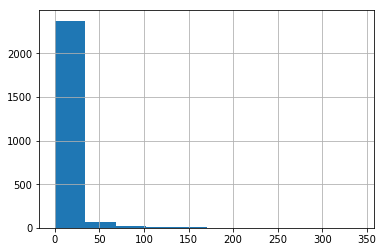

In [60]:
# посмотрим на распределение
df_2['likes_per_repost'].hist()

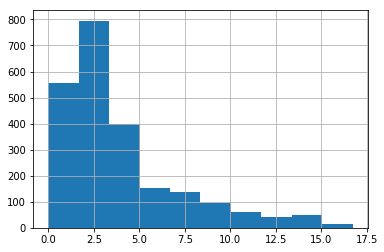

In [61]:
# найдем, сколько нужно отбросить крайних значений, чтобы распределение стало похожим на классическое
quantile = 0.93 # подбираем это значение
columnName = 'likes_per_repost'
barrier = df_2[columnName].quantile(quantile) # проходное значение. Все, что за пределами - отбросим
df_2_tmp = df_2[df_2[columnName] < barrier].copy()
df_2_tmp['likes_per_repost'].hist()
# результат наблюдений - если ввести строгий коэффициент k такой что кол-во лайков = k * кол-во репостов,
#   тогда погрешность будет весьма большой, т.к. значения сильно распределены (см.chart)

In [62]:
"""
Ответ на вопрос N2

Корреляция существует между likes_count, reposts_count.
Но, comments_count - является относительно независимой величиной и ее лучше рассматривать отдельно.
Ввести величину "интерес к публикации" - возможно.
Но, для точных коэффициентов, с которыми вносить лайки и репосты - требуется дополнительное исследование.
"""

'\nОтвет на вопрос N2\n\nКорреляция существует между likes_count, reposts_count.\nНо, comments_count - является относительно независимой величиной и ее лучше рассматривать отдельно.\nВвести величину "интерес к публикации" - возможно.\nНо, для точных коэффициентов, с которыми вносить лайки и репосты - требуется дополнительное исследование.\n'

In [63]:
# найдем ответ на вопрос N3

In [64]:
# введем dataframe, который используем для поиска ответа на вопрос N3
df_3 = df.copy()

In [65]:
# введем величину, которую считаем "интерес к публикации"
K_COMMENTS = 1.0 # коэффициент, с которым вносим комментарий
K_LIKES = 1.0 # коэффициент, с которым вносим лайки
K_REPOSTS = 1.0  # коэффициент, с которым вносим репосты
def interest_func(row):
    return K_COMMENTS * row['comments_count'] + K_LIKES * row['likes_count'] + K_REPOSTS * row['reposts_count']

In [66]:
# создаем новый столбец
df_3['interest_rate'] = df_3.apply(interest_func, axis=1)
# удалим записи, где интерес = 0 - они нас не интересуют
df_3 = df_3[df_3['interest_rate'] > 0]

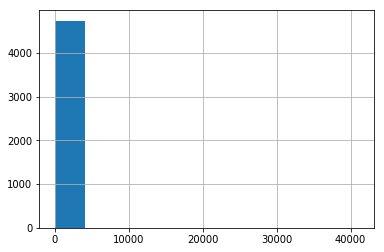

In [67]:
# посмотрим распределение
df_3['interest_rate'].hist()
# по наблюдению - стоит раздельно расмотреть строки: которые рядом с медианой, и которые выше некоторой квантили

In [68]:
# будем подбирать эти значение
QUANTILE_LOW = 0.85 # меньше этого значения - слабый интерес, выше - интерес есть
QUANTILE_HIGH = 0.97 # выше этого значения - выброс. То есть, накрутка или что-либо еще.

# разделяем
columnName = 'interest_rate'
barrier_low = df_3[columnName].quantile(QUANTILE_LOW) # в виде числа
barrier_high = df_3[columnName].quantile(QUANTILE_HIGH) # в виде числа
df_3_minor = df_3[df_3[columnName] < barrier_low].copy()
df_tmp = df_3[df_3[columnName] >= barrier_low].copy()
df_3_target = df_tmp[df_tmp[columnName] < barrier_high].copy()
df_3_untrust = df_tmp[df_tmp[columnName] >= barrier_high].copy()

count    4025.000000
mean        6.622112
std         5.721290
min         1.000000
25%         2.000000
50%         5.000000
75%        10.000000
max        25.000000
Name: interest_rate, dtype: float64

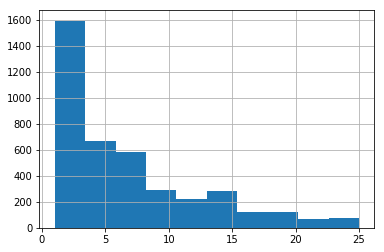

In [69]:
df_3_minor['interest_rate'].hist()
df_3_minor['interest_rate'].describe()

count    568.000000
mean      64.802817
std       42.003819
min       26.000000
25%       34.000000
50%       47.000000
75%       81.000000
max      181.000000
Name: interest_rate, dtype: float64

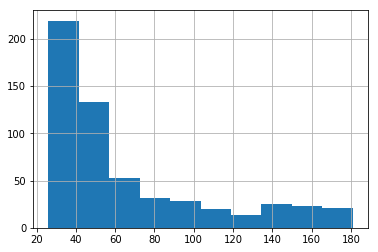

In [70]:
df_3_target['interest_rate'].hist()
df_3_target['interest_rate'].describe()

count      146.000000
mean      1046.349315
std       3668.833222
min        182.000000
25%        227.000000
50%        332.500000
75%        635.000000
max      41123.000000
Name: interest_rate, dtype: float64

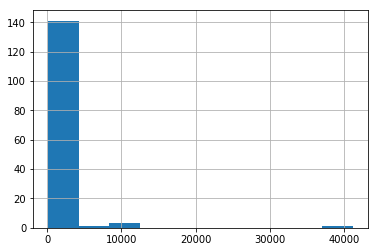

In [71]:
df_3_untrust['interest_rate'].hist()
df_3_untrust['interest_rate'].describe()

In [72]:
# теперь найдем сообщества, в которых чаще всего встречаются сообщения из целевой группы
df_3_grouped = df_3_target.groupby('group_id').first() # создаем dataframe с уникальными group_id
df_3_grouped['count'] = df_3_target['group_id'].value_counts() # проставляем кол-во, сколько раз встречается
series_3_top = df_3_grouped['count'].sort_values(ascending=False)

In [73]:
# выводим результат
series_3_top.head()

group_id
122422421    93
43011371     56
53986544     52
158943684    51
21178038     32
Name: count, dtype: int64

In [74]:
"""
Ответ на вопрос N3

Мы определили, в каких сообществах встречается более всего публикаций, которые вызывают интерес у посетителей
"""

'\nОтвет на вопрос N3\n\nМы определили, в каких сообществах встречается более всего публикаций, которые вызывают интерес у посетителей\n'